## Load the Libraries

In [ ]:
import pandas as pd
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
import numpy as np
import torch 


## Load the Data

In [2]:
df = pd.read_csv("hf://datasets/scikit-fingerprints/MoleculeNet_ClinTox/clintox.csv")
df.head()
#podríamos unirlo con otro dataset de toxicidad para tener más features?

/Users/annagilmoliner/CD_2025_2026/MLN/ClinTox/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,SMILES,FDA_APPROVED,CT_TOX
0,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
1,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
2,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
3,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0
4,[N+](=O)([O-])[O-],1,0


In [3]:
df.shape


(1477, 3)

In [4]:
toxicity = df['CT_TOX']
toxicity.value_counts()
# tenemos q hacer el split de manera que haya el mismo 
# porcentaje de toxicos y no toxicos en la muestra

CT_TOX
0    1365
1     112
Name: count, dtype: int64

Convert one example of SMILE to a molecular fingerprint using rdkit

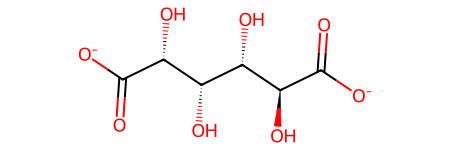

In [5]:
example_smile = df.loc[1, "SMILES"]
mol = Chem.MolFromSmiles(example_smile)
mol

### Process the entire dataset to obtain molecular fingerprints

In [6]:
pgen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024) #with radius=2, are roughly equivalent to ECFP4 and FCFP4.
# compact 1024-bit numerical representation of molecular structure


mols = df["SMILES"].map(lambda x: Chem.MolFromSmiles(x))
fps_ = mols.map(lambda x: pgen.GetFingerprint(x))
fps = np.concatenate([np.array(l).reshape(1, 1024) for l in fps_], axis = 0)
fps.shape

(1477, 1024)

In [7]:
fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1477, 1024))

# Predictions

1. Try to predict first with classical ML, Random Forest with ECFP4 fingerprints
2. Try to predict with GNN.
3. Compare the results.

## Classical ML with Random Forest

Try to predict first with classical ML, Random Forest with ECFP4 fingerprints

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into features (X) and target variable (y)
X = fps
y = df["CT_TOX"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size = 0.2,
                                                       random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Initialize the Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # expand until all leaves are pure or contain <2 samples
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # probability of positive class

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"✅ Accuracy: {acc:.3f}")
print(f"✅ ROC-AUC: {auc:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))
#solo es una prueba, no es fiable el acc porque al final el dataset está desbalanceado.

✅ Accuracy: 0.916
✅ ROC-AUC: 0.801

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       275
           1       0.25      0.10      0.14        21

    accuracy                           0.92       296
   macro avg       0.59      0.54      0.55       296
weighted avg       0.89      0.92      0.90       296



In [13]:
##otra prueba
import pandas as pd
import numpy as np
import deepchem as dc
import torch


# --- 1. Load DataFrame ---
df = df.iloc[:,-2:].copy()
df.columns = ['SMILES', 'CT_TOX'] # Ensure column names are standardized

# --- 2. Define Tasks and Featurizer ---
tasks = ['CT_TOX']
featurizer = dc.feat.ConvMolFeaturizer() #Type of graph convolution featurizer (Duvenaud)

# --- New Robust Data Loading ---
print("Featurizing SMILES...")
X_features = featurizer.featurize(df['SMILES'].tolist())
Y_labels = df[tasks].values.astype(np.float32)
# Create the DeepChem NumpyDataset
dataset = dc.data.NumpyDataset(X=X_features, y=Y_labels, ids=df['SMILES'].values)

Failed to featurize datapoint 0, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 1, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 2, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 3, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 4, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 5, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 6, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 7, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 8, 1. Appending empty arra

Featurizing SMILES...


Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 276, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 277, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 278, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 279, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 280, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 281, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 282, 1. Appending empty array
Exception message: 'int' object has no attribute 'GetAtoms'
Failed to featurize datapoint 283, 1. Appending empty array
Exception message: 'int' object has no a